In [1]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom
import seaborn as sns
matplotlib.rcParams['image.cmap'] = 'bone'

In [2]:
path = Path('D:/Datasets/TN_SC')
os.listdir(path)

['image', 'mask', 'TNSCUI2020_train.rar', 'train.csv']

In [3]:
images = path/'image'
masks = path/'mask'
image_items = get_image_files(images)
mask_items = get_image_files(masks)
image_items, mask_items

((#3644) [Path('D:/Datasets/TN_SC/image/100.PNG'),Path('D:/Datasets/TN_SC/image/1002.PNG'),Path('D:/Datasets/TN_SC/image/1004.PNG'),Path('D:/Datasets/TN_SC/image/1010.PNG'),Path('D:/Datasets/TN_SC/image/1012.PNG'),Path('D:/Datasets/TN_SC/image/102.PNG'),Path('D:/Datasets/TN_SC/image/1020.PNG'),Path('D:/Datasets/TN_SC/image/1024.PNG'),Path('D:/Datasets/TN_SC/image/1026.PNG'),Path('D:/Datasets/TN_SC/image/1029.PNG')...],
 (#3644) [Path('D:/Datasets/TN_SC/mask/100.PNG'),Path('D:/Datasets/TN_SC/mask/1002.PNG'),Path('D:/Datasets/TN_SC/mask/1004.PNG'),Path('D:/Datasets/TN_SC/mask/1010.PNG'),Path('D:/Datasets/TN_SC/mask/1012.PNG'),Path('D:/Datasets/TN_SC/mask/102.PNG'),Path('D:/Datasets/TN_SC/mask/1020.PNG'),Path('D:/Datasets/TN_SC/mask/1024.PNG'),Path('D:/Datasets/TN_SC/mask/1026.PNG'),Path('D:/Datasets/TN_SC/mask/1029.PNG')...])

In [4]:
tst_img = image_items[17]
tst_msk = mask_items[7]

In [5]:
get_msk = lambda o: path/'mask'/f'{o.stem}{o.suffix}'
get_msk

<function __main__.<lambda>(o)>

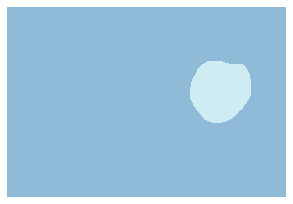

In [6]:
msk = PILMask.create(get_msk(tst_img))
msk.show(figsize=(5,5), alpha=0.5)

In [7]:
batch_tfms = [IntToFloatTensor(div_mask=128), Normalize.from_stats(*imagenet_stats)]
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]

tnsc = DataBlock(blocks=(ImageBlock, MaskBlock),
                   get_items=get_image_files,
                   #splitter=RandomSplitter(),
                   get_y=get_msk,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [8]:
tnsc.summary(path)

Setting-up type transforms pipelines
Found 7288 items
2 datasets of sizes 5831,1457
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      D:\Datasets\TN_SC\mask\6564.PNG
    applying PILBase.create gives
      PILImage mode=RGB size=716x660
  Pipeline: <lambda> -> PILBase.create
    starting from
      D:\Datasets\TN_SC\mask\6564.PNG
    applying <lambda> gives
      D:\Datasets\TN_SC\mask\6564.PNG
    applying PILBase.create gives
      PILMask mode=L size=716x660

Final sample: (PILImage mode=RGB size=716x660, PILMask mode=L size=716x660)


Setting up after_item: Pipeline: AddMaskCodes -> RandomResizedCrop -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> Normalize

Building one batch
Applying item_tfms to the first sample:
  Pipeline: AddMaskCodes -> RandomResizedCrop -> ToTensor
    starting from
      (PILImage mode=RGB size=716x

In [9]:
dls = tnsc.dataloaders(path/'image', bs=2, num_workers=0)

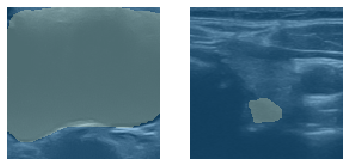

In [10]:
dls.show_batch()

In [15]:
#learn = unet_learner(dls, xresnet50,n_out=2)
learn = unet_learner(dls, resnet18, n_out=2)

In [16]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,time
0,0.270087,0.195454,04:01


epoch,train_loss,valid_loss,time
0,0.148025,0.123742,12:09


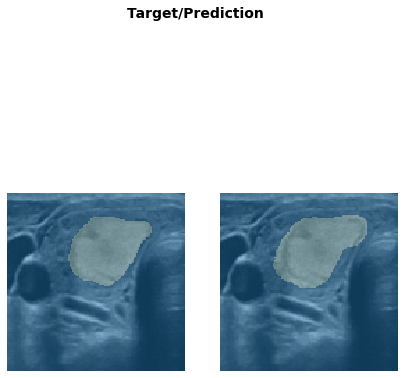

In [17]:
learn.show_results(max_n=4, figsize=(7,8))